In [1]:
# Download the dataset from Kaggle.
# Kaggle-dən verilənlər dəstini yükləyin.
!curl -L -o pizza-steak-image-classification-dataset.zip https://www.kaggle.com/api/v1/datasets/download/kelixirr/pizza-steak-image-classification-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  104M  100  104M    0     0  67.3M      0  0:00:01  0:00:01 --:--:--  177M


In [2]:
# Unzip the downloaded dataset.
# Yüklənmiş verilənlər dəstini arxivdən çıxarın.
!unzip /content/pizza-steak-image-classification-dataset.zip

Archive:  /content/pizza-steak-image-classification-dataset.zip
  inflating: pizza_steak/test/pizza/1001116.jpg  
  inflating: pizza_steak/test/pizza/1032754.jpg  
  inflating: pizza_steak/test/pizza/103708.jpg  
  inflating: pizza_steak/test/pizza/1060407.jpg  
  inflating: pizza_steak/test/pizza/106507.jpg  
  inflating: pizza_steak/test/pizza/1067986.jpg  
  inflating: pizza_steak/test/pizza/1106738.jpg  
  inflating: pizza_steak/test/pizza/1119571.jpg  
  inflating: pizza_steak/test/pizza/11297.jpg  
  inflating: pizza_steak/test/pizza/1152100.jpg  
  inflating: pizza_steak/test/pizza/1179703.jpg  
  inflating: pizza_steak/test/pizza/1180001.jpg  
  inflating: pizza_steak/test/pizza/1180273.jpg  
  inflating: pizza_steak/test/pizza/1183595.jpg  
  inflating: pizza_steak/test/pizza/1202689.jpg  
  inflating: pizza_steak/test/pizza/121960.jpg  
  inflating: pizza_steak/test/pizza/1220156.jpg  
  inflating: pizza_steak/test/pizza/1223284.jpg  
  inflating: pizza_steak/test/pizza/12263

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models # Using the 'models' library for pre-trained models.
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image # For image prediction.

# Determine the device for computation (CUDA if GPU is available, otherwise CPU).
# Hesablama üçün cihazı müəyyən edin (GPU varsa CUDA, yoxsa CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}") # Print the device being used.

# Image size (ResNet typically expects 224x224).
# Şəkil ölçüsü (ResNet adətən 224x224 gözləyir).
IMG_SIZE = 224

Kullanılan cihaz: cuda


In [26]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

def get_mean_std(data_dir, image_size=(224, 224), batch_size=64):
    """
    Function to automatically calculate mean and std values from images in the dataset.
    Verilənlər dəstindəki şəkillərdən orta (mean) və standart kənarlaşma (std) dəyərlərini avtomatik hesablamaq üçün funksiyadır.
    -- data_dir: Path to the dataset folder (e.g., train or a folder containing all images).
    - data_dir: Verilənlər dəsti qovluğunun yolu (məsələn, 'train' və ya bütün şəkillərin yerləşdiyi qovluq).
    -- image_size: Target image size (W, H).
    - image_size: Hədəf şəkil ölçüsü (W, H).
    -- batch_size: DataLoader batch size.
    - batch_size: DataLoader batch ölçüsü.
    """
    # Transformation before normalization.
    # Normalizasiyadan əvvəlki çevrilmə.
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        # Reshape: [B, C, H, W] to [B, C, H*W]
        # Şəkil ölçüsünü dəyişdir: [B, C, H, W] -dən [B, C, H*W] -ə.
        images = images.view(images.size(0), images.size(1), -1)
        total_images_count += images.size(0)
        mean += images.mean(dim=2).sum(dim=0)
        std += images.std(dim=2).sum(dim=0)

    mean /= total_images_count
    std /= total_images_count

    return mean.tolist(), std.tolist()

# Calculate mean and std for the training dataset.
# Təlim verilənlər dəsti üçün orta və standart kənarlaşmanı hesablayın.
mean_train, std_train = get_mean_std(data_dir="/content/pizza_steak/train", image_size=(224, 224))
print("Mean:", mean_train)
print("Std:", std_train)

# Calculate mean and std for the test dataset.
# Test verilənlər dəsti üçün orta və standart kənarlaşmanı hesablayın.
mean_test, std_test = get_mean_std(data_dir="/content/pizza_steak/test", image_size=(224, 224))
print("Mean:", mean_test)
print("Std:", std_test)

Mean: [0.5349233150482178, 0.4092333912849426, 0.31205740571022034]
Std: [0.2350262850522995, 0.24265818297863007, 0.22830381989479065]
Mean: [0.5383775234222412, 0.4175134003162384, 0.31927359104156494]
Std: [0.23636789619922638, 0.24725843966007233, 0.23436440527439117]


In [27]:
# Transformations for the training dataset.
# Təlim verilənlər dəsti üçün çevrilmələr.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train, std=std_train) # Use std_train here
])

# Transformations for the test and prediction datasets.
# Test və proqnoz verilənlər dəstləri üçün çevrilmələr.
test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_test, std=std_test)
])

In [28]:
# Main path for your dataset.
# Verilənlər dəstinizin əsas yolu.
data_dir = 'pizza_steak'

# Load the training and test datasets.
# Təlim və test verilənlər dəstlərini yükləyin.
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# Get class names (needed for the prediction function).
# Sinif adlarını əldə edin (proqnoz funksiyası üçün lazımdır).
class_names = train_data.classes
print(f"Sınıf isimleri: {class_names}") # Print the class names.
print(f"Eğitim veri seti boyutu: {len(train_data)}") # Print the size of the training dataset.
print(f"Test veri seti boyutu: {len(test_data)}") # Print the size of the test dataset.

# Batch size for DataLoaders.
# DataLoader-lar üçün batch ölçüsü.
BATCH_SIZE = 32

# Create DataLoaders.
# DataLoader-ları yaradın.
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Eğitim DataLoader'ı için batch sayısı: {len(train_dataloader)}") # Print the number of batches for the training DataLoader.
print(f"Test DataLoader'ı için batch sayısı: {len(test_dataloader)}") # Print the number of batches for the test DataLoader.

Sınıf isimleri: ['pizza', 'steak']
Eğitim veri seti boyutu: 1500
Test veri seti boyutu: 500
Eğitim DataLoader'ı için batch sayısı: 47
Test DataLoader'ı için batch sayısı: 16


In [29]:
# Load a pre-trained ResNet18 model.
# 'weights=models.ResNet18_Weights.DEFAULT' downloads the latest and recommended weights.
# Əvvəlcədən təlim keçmiş ResNet18 modelini yükləyin.
# 'weights=models.ResNet18_Weights.DEFAULT' ən son və tövsiyə olunan çəkiləri yükləyir.
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all parameters (optional but good practice initially).
# This prevents the pre-trained layers from changing during training.
# We will only train the final layer.
# Bütün parametrləri dondurun (isteğe bağlı, lakin başlanğıcda yaxşı bir təcrübədir).
# Bu, əvvəlcədən təlim keçmiş qatların təlim zamanı dəyişməsinin qarşısını alır.
# Yalnız son qatı təlim edəcəyik.
for param in model.parameters():
    param.requires_grad = False

# The final layer of ResNet is called 'fc' (fully connected).
# We get the number of input features for this layer.
# ResNet-in son qatı 'fc' (tam bağlı) adlanır.
# Bu qat üçün giriş xüsusiyyətlərinin sayını əldə edirik.
num_ftrs = model.fc.in_features

# Create a new fully connected layer to match our number of classes (2: pizza, steak).
# Sinif sayımıza (2: pizza, steak) uyğun yeni bir tam bağlı qat yaradırıq.
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device) # Move the model to the selected device.

print(model) # Print the model structure to verify changes.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# Loss function.
# İtkilər funksiyası.
criterion = nn.CrossEntropyLoss()

# Optimizer (only optimize trainable parameters).
# This means only the parameters of the newly added model.fc layer will be trained.
# Optimallaşdırıcı (yalnız təlim keçə bilən parametrləri optimallaşdırın).
# Bu o deməkdir ki, yalnız yeni əlavə etdiyimiz model.fc qatının parametrləri təlim keçəcək.
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate.

In [31]:
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=20):
    # Loop through each epoch.
    # Hər epoxa üzrə dövr edin.
    for epoch in range(num_epochs):
        model.train() # Set the model to training mode.
        running_loss = 0.0
        running_corrects = 0

        # Iterate over training data.
        # Təlim verilənləri üzərində təkrarlayın.
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Zero the gradients.

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # Get the class with the highest probability.
            loss = criterion(outputs, labels)

            loss.backward() # Backpropagation.
            optimizer.step() # Update parameters.

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        model.eval() # Set the model to evaluation mode.
        test_loss = 0.0
        test_corrects = 0
        with torch.no_grad(): # Disable gradient calculation.
            # Iterate over test data.
            # Test verilənləri üzərində təkrarlayın.
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                test_corrects += torch.sum(preds == labels.data)

        test_epoch_loss = test_loss / len(test_dataloader.dataset)
        test_epoch_acc = test_corrects.double() / len(test_dataloader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}")

# Train the model.
# Modeli təlim edin.
train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=20)

Epoch 1/20 - Train Loss: 0.5349 Acc: 0.7280
Epoch 1/20 - Test Loss: 0.2354 Acc: 0.9560
Epoch 2/20 - Train Loss: 0.3234 Acc: 0.8893
Epoch 2/20 - Test Loss: 0.1434 Acc: 0.9720
Epoch 3/20 - Train Loss: 0.2716 Acc: 0.8947
Epoch 3/20 - Test Loss: 0.1131 Acc: 0.9840
Epoch 4/20 - Train Loss: 0.2365 Acc: 0.9080
Epoch 4/20 - Test Loss: 0.0950 Acc: 0.9840
Epoch 5/20 - Train Loss: 0.2222 Acc: 0.9133
Epoch 5/20 - Test Loss: 0.0817 Acc: 0.9860
Epoch 6/20 - Train Loss: 0.2351 Acc: 0.9107
Epoch 6/20 - Test Loss: 0.0741 Acc: 0.9880
Epoch 7/20 - Train Loss: 0.2077 Acc: 0.9167
Epoch 7/20 - Test Loss: 0.0722 Acc: 0.9880
Epoch 8/20 - Train Loss: 0.2102 Acc: 0.9207
Epoch 8/20 - Test Loss: 0.0650 Acc: 0.9900
Epoch 9/20 - Train Loss: 0.2017 Acc: 0.9167
Epoch 9/20 - Test Loss: 0.0701 Acc: 0.9840
Epoch 10/20 - Train Loss: 0.1870 Acc: 0.9307
Epoch 10/20 - Test Loss: 0.0664 Acc: 0.9900
Epoch 11/20 - Train Loss: 0.2083 Acc: 0.9173
Epoch 11/20 - Test Loss: 0.0745 Acc: 0.9780
Epoch 12/20 - Train Loss: 0.1859 Acc: 0

In [32]:
import torch.nn.functional as F

def predict_image_with_plot(image_path, model = model, class_names = class_names, device = device, mean = mean_test, std = std_test, img_size=224):
    """
    Predicts the class for a given image and visualizes the result with matplotlib.
    Verilmiş şəkil üçün sinifi proqnozlaşdırır və nəticəni matplotlib ilə vizual olaraq göstərir.
    """
    # Set the model to evaluation mode.
    # Modeli qiymətləndirmə rejiminə keçirin.
    model.eval()

    # Define the same preprocessing steps used during testing.
    # Test zamanı istifadə olunan eyni əvvəlcədən emal addımlarını müəyyənləşdirin.
    preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Load and preprocess the image.
    # Şəkli yükləyin və emal edin.
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device) # Add batch dimension and move to device.

    # Get prediction.
    # Proqnozu əldə edin.
    with torch.no_grad(): # Disable gradient calculation for inference.
        logits = model(image_tensor)
        probs = F.softmax(logits, dim=1) # Convert logits to probabilities.
        confidence, predicted = torch.max(probs, 1) # Get the highest probability and its index.

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()

    # Display with plot.
    # Plot ilə göstərin.
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off") # Turn off axis.
    plt.title(f"Təxmin: {predicted_class} ({confidence_score:.2f})", fontsize=14)
    plt.show()

In [33]:
!wget https://github.com/bahramzada/image-classifier-pytorch/raw/main/test_images.zip


--2025-07-01 20:17:44--  https://github.com/bahramzada/image-classifier-pytorch/raw/main/test_images.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bahramzada/image-classifier-pytorch/main/test_images.zip [following]
--2025-07-01 20:17:45--  https://raw.githubusercontent.com/bahramzada/image-classifier-pytorch/main/test_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4196619 (4.0M) [application/zip]
Saving to: ‘test_images.zip.1’

test_images.zip.1   100%[===================>]   4.00M  --.-KB/s    in 0.05s   

2025-07-01 20:17:45 (74.1 MB/s) - ‘test_images.zip.1’ saved [4196619/4

In [34]:
!unzip '/content/test_images.zip' -d 'test_images'

Archive:  /content/test_images.zip
  inflating: test_images/5.jpg       
  inflating: test_images/4.jpg       
  inflating: test_images/3.jpg       
  inflating: test_images/2.jpg       
  inflating: test_images/1.jpg       


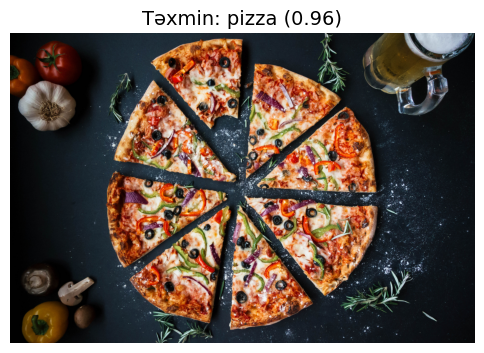

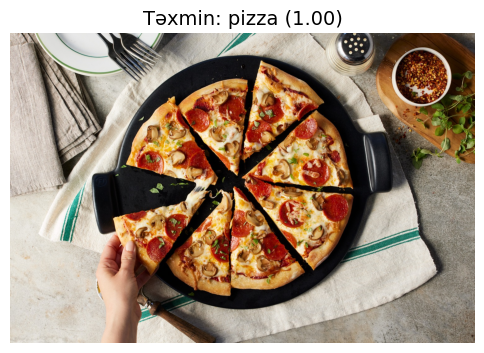

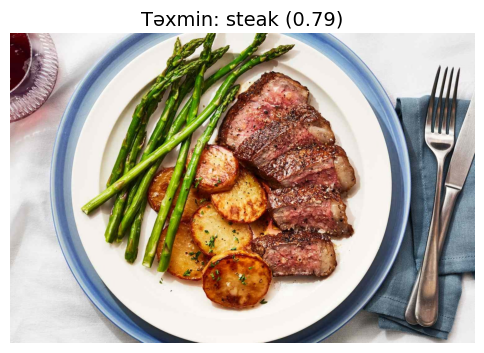

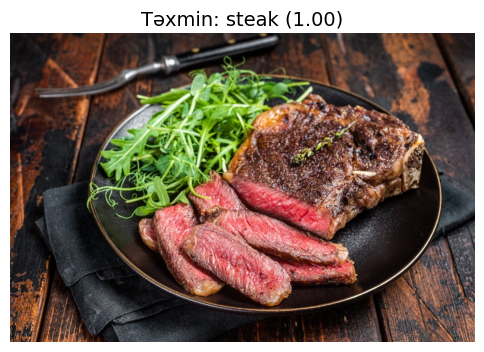

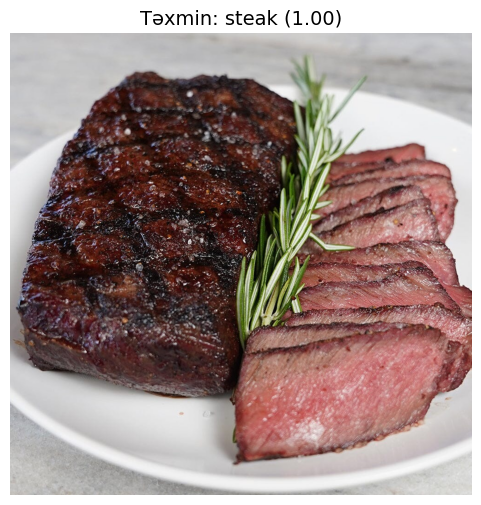

In [35]:
# Loop through example images and make predictions.
# Nümunə şəkillər üzərində dövr edin və proqnozlar verin.
for i in range(1,6):
    image_path = f'/content/test_images/{i}.jpg'
    predict_image_with_plot(image_path)